# MS026 Preprocess
06/18/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS026'
subj_format = ['edf']
subj_site = ['MSSM']


### Import Data

In [5]:
edf_files = glob(f'{neural_dir}/MS026/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


In [6]:
mne_data

<RawEDF | MS026_SWB.edf, 276 x 3340032 (3261.7 s), ~6.87 GB, data loaded>

In [8]:
mne_data.ch_names

['LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'RmOlF1',
 'RmOlF2',
 'RmOlF3',
 'RmOlF4',
 'RmOlF5',
 'RmOlF6',
 'RmOlF7',
 'RmOlF8',
 'RmOlF9',
 'LCMsP1',
 'LCMsP2',
 'LCMsP3',
 'LCMsP4',
 'LCMsP5',
 'LCMsP6',
 'LCMsP7',
 'LCMsP8',
 'LCMsP9',
 'LCMsP10',
 'LCMsP11',
 'LCMsP12',
 'LCMsP13',
 'LCMsP14',
 'C33',
 'C34',
 'RCMsP1',
 'RCMsP2',
 'RCMsP3',
 'RCMsP4',
 'RCMsP5',
 'RCMsP6',
 'RCMsP7',
 'RCMsP8',
 'RCMsP9',
 'RCMsP10',
 'RCMsP11',
 'RCMsP12',
 'RCMsP13',
 'RCMsP14',
 'RCMsP15',
 'RCMsP16',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS13',
 'LaCaS14',
 'RaCaS1',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'RaCaS13',
 'RaCaS14',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'RmCmS1',
 'Rm

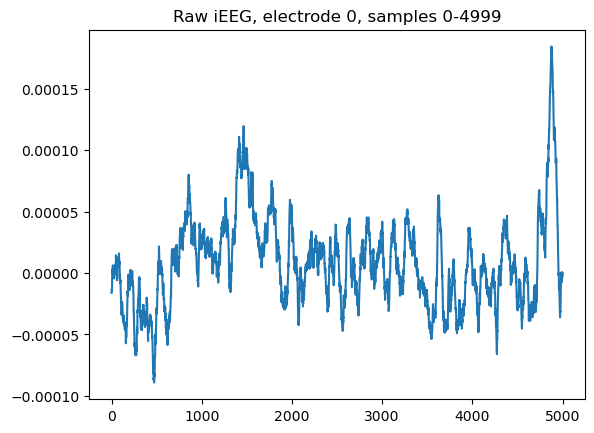

In [9]:
# Sanity check one channel data
plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Examine photodiode

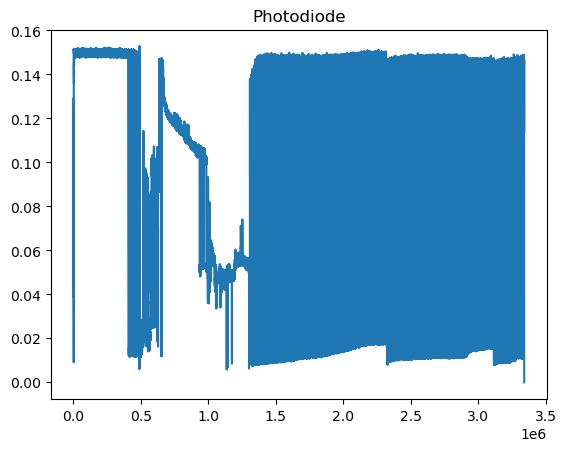

In [10]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

### Import Anat Recon Info - check all elecs are present in data + recon sheet


### Fix edf channel names

In [11]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}/MS026_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

NMMlabel BN246label          x          y          z      mni_x  \
0     LaCaS1    A32sg_L  -2.954574  41.329210   4.799997  -3.150189   
1    LaCaS10   A9/46d_L -14.150090  45.726392  48.399994 -14.612690   
2    LaCaS11      A9l_L -15.349610  46.126136  53.199994 -16.068791   
3    LaCaS12      A9l_L -16.149290  46.126136  57.999994 -17.096981   
4    LaCaS13    Unknown -16.948969  46.126136  63.599993 -18.060868   
..       ...        ...        ...        ...        ...        ...   
163   RmOlF6     A11l_R  33.430855  50.123574   8.399997  36.273305   
164   RmOlF7  A12/47o_R  37.429254  49.723831  10.399996  40.477926   
165   RmOlF8  A12/47l_R  42.227333  49.723831  12.399996  45.600992   
166   RmOlF9     A45r_R  46.625571  49.723831  14.799996  50.223671   
167   uRmOlF      A13_R   7.441263  48.524599  -4.000003   8.405835   

         mni_y      mni_z       gm  \
0    27.626674 -11.313929     Gray   
1    45.647438  30.886915    White   
2    47.523347  35.735259     Gray   
3    48.985539  40.715012     Gray   
4    50.562598  46.419275  Unknown   
..         ...        ...      ...   
163  37.087206 -11.909190     Gray   
164  37.432671  -9.831393     Gray   
165  38.133258  -7.732312     Gray   
166  38.960073  -5.163690     Gray   
167  31.034159 -22.937916     Gray   

                                                   NMM      Anat  \
0                   Left ACgG anterior cingulate gyrus  Area s24   
1                           Left Cerebral White Matter   Unknown   
2                      Left SFG superior frontal gyrus   Unknown   
3                      Left SFG superior frontal gyrus   Unknown   
4                                              Unknown   Unknown   
..                                                 ...       ...   
163                   Right LOrG lateral orbital gyrus   Unknown   
164                        Right Cerebral White Matter   Unknown   
165  Right OrIFG orbital part of the inferior front...   Unknown   
166  Right TrIFG triangular part of the inferior fr...   Unknown   
167                             Right GRe gyrus rectus  Area Fo1   

                    AnatMacro    BN246                               YBA_1  \
0         L Mid Orbital Gyrus     L CG              Left cingulate gyrus C   
1    L Superior Frontal Gyrus    L MFG                             Unknown   
2    L Superior Frontal Gyrus    L SFG     Left superior frontal gyrus 2 D   
3    L Superior Frontal Gyrus    L SFG     Left superior frontal gyrus 2 D   
4    L Superior Frontal Gyrus  Unknown     Left superior frontal gyrus 2 D   
..                        ...      ...                                 ...   
163       R IFG (p Orbitalis)    R OrG              Right pars orbitalis B   
164       R IFG (p Orbitalis)    R OrG              Right pars orbitalis B   
165       R IFG (p Orbitalis)    R OrG  Right anterior pars triangularis A   
166       R IFG (p Orbitalis)    R IFG  Right anterior pars triangularis A   
167            R Rectal Gyrus    R OrG           Right frontal orbital 4 A   

    Manual Examination  Notes  
0                  NaN    NaN  
1                   WM    NaN  
2                   WM    NaN  
3                  OOB    NaN  
4                  OOB    NaN  
..                 ...    ...  
163                 WM    NaN  
164                NaN    NaN  
165                NaN    NaN  
166                NaN    NaN  
167                NaN    NaN  

[168 rows x 16 columns]

In [13]:
list(elec_locs.NMMlabel)

['LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS13',
 'LaCaS14',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LCMsP1',
 'LCMsP10',
 'LCMsP11',
 'LCMsP12',
 'LCMsP13',
 'LCMsP14',
 'LCMsP2',
 'LCMsP3',
 'LCMsP4',
 'LCMsP5',
 'LCMsP6',
 'LCMsP7',
 'LCMsP8',
 'LCMsP9',
 'LHplT1',
 'LHplT10',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'uLHplT',
 'LHtOc1',
 'LHtOc10',
 'LHtOc11',
 'LHtOc12',
 'LHtOc13',
 'LHtOc14',
 'LHtOc15',
 'LHtOc16',
 'LHtOc2',
 'LHtOc3',
 'LHtOc4',
 'LHtOc5',
 'LHtOc6',
 'LHtOc7',
 'LHtOc8',
 'LHtOc9',
 'LmCmS1',
 'LmCmS10',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'uLmOlF',
 'RaCaS1',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'RaCaS13'

In [15]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.NMMlabel)


In [16]:
unmatched_names

['uraglt', 'ulhplt', 'ulmolf', 'urmolf']

In [17]:
unmatched_seeg  #make sure there are no unmatched names

[]

In [18]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [19]:
new_name_dict

{'LmOlF1': 'lmolf1',
 'LmOlF2': 'lmolf2',
 'LmOlF3': 'lmolf3',
 'LmOlF4': 'lmolf4',
 'LmOlF5': 'lmolf5',
 'LmOlF6': 'lmolf6',
 'LmOlF7': 'lmolf7',
 'LmOlF8': 'lmolf8',
 'LmOlF9': 'lmolf9',
 'RmOlF1': 'rmolf1',
 'RmOlF2': 'rmolf2',
 'RmOlF3': 'rmolf3',
 'RmOlF4': 'rmolf4',
 'RmOlF5': 'rmolf5',
 'RmOlF6': 'rmolf6',
 'RmOlF7': 'rmolf7',
 'RmOlF8': 'rmolf8',
 'RmOlF9': 'rmolf9',
 'LCMsP1': 'lcmsp1',
 'LCMsP2': 'lcmsp2',
 'LCMsP3': 'lcmsp3',
 'LCMsP4': 'lcmsp4',
 'LCMsP5': 'lcmsp5',
 'LCMsP6': 'lcmsp6',
 'LCMsP7': 'lcmsp7',
 'LCMsP8': 'lcmsp8',
 'LCMsP9': 'lcmsp9',
 'LCMsP10': 'lcmsp10',
 'LCMsP11': 'lcmsp11',
 'LCMsP12': 'lcmsp12',
 'LCMsP13': 'lcmsp13',
 'LCMsP14': 'lcmsp14',
 'C33': 'c33',
 'C34': 'c34',
 'RCMsP1': 'rcmsp1',
 'RCMsP2': 'rcmsp2',
 'RCMsP3': 'rcmsp3',
 'RCMsP4': 'rcmsp4',
 'RCMsP5': 'rcmsp5',
 'RCMsP6': 'rcmsp6',
 'RCMsP7': 'rcmsp7',
 'RCMsP8': 'rcmsp8',
 'RCMsP9': 'rcmsp9',
 'RCMsP10': 'rcmsp10',
 'RCMsP11': 'rcmsp11',
 'RCMsP12': 'rcmsp12',
 'RCMsP13': 'rcmsp13',
 'RCMsP

In [20]:
# Rename the mne data according to the localization data
mne_data.rename_channels(new_name_dict)

<RawEDF | MS026_SWB.edf, 276 x 3340032 (3261.7 s), ~6.87 GB, data loaded>

In [21]:
unmatched_seeg

[]

In [22]:
anat_names = list(elec_locs.NMMlabel.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['c33', 'c34', 'rcmsp15', 'rcmsp16', 'c127', 'c128', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'abs1', 'abs2', 'chest1', 'chest2', 'c196', 'c197', 'c198', 'c199', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', 'c223', 'c224', 'c225', 'c226', 'c227', 'c228', 'c229', 'c230', 'c231', 'c232', 'c233', 'c234', 'c235', 'c236', 'c237', 'c238', 'c239', 'c240', 'c241', 'c242', 'c243', 'c244', 'c245', 'c246', 'c247', 'c248', 'c249', 'c250', 'c251', 'c252', 'c253', 'c254', 'c255', 'c256', 'dc1', 'dc2', 'dc3', 'dc4', 'dc5', 'dc6', 'dc7', 'dc8', 'dc9', 'dc10', 'dc11', 'dc12', 'dc13', 'dc14', 'dc15', 'dc16', 'trig', 'osat', 'pr', 'pleth']


In [23]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of', len(left_seeg_names), 'left &', len(right_seeg_names), 'right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')


We have a total of 82 left & 84 right sEEG electrodes
We have a total of 166 sEEG electrodes


In [24]:
list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['dc1'])) #list of non seeg/photodiode channels

['f8',
 'c231',
 'dc3',
 'c243',
 'o1',
 'fp2',
 'c216',
 'f3',
 'c226',
 'dc7',
 'chest2',
 'chest1',
 'c253',
 'c206',
 'c218',
 'c240',
 'c244',
 'c213',
 'dc5',
 'c197',
 't6',
 'ekg2',
 'c219',
 't5',
 'fz',
 'f4',
 'c196',
 'c221',
 'dc15',
 'c247',
 'c205',
 'c211',
 'c251',
 'f7',
 'c202',
 'c215',
 'c127',
 'c200',
 't4',
 'c201',
 'c230',
 'p4',
 'dc12',
 'c233',
 'c209',
 'c252',
 'osat',
 'dc4',
 'dc13',
 't3',
 'c250',
 'c255',
 'c238',
 'dc10',
 'p3',
 'c203',
 'abs2',
 'c207',
 'dc9',
 'c241',
 'c3',
 'c199',
 'pz',
 'c254',
 'trig',
 'c224',
 'cz',
 'pr',
 'fp1',
 'pleth',
 'c256',
 'c245',
 'c228',
 'abs1',
 'dc8',
 'c242',
 'dc14',
 'c212',
 'c225',
 'c222',
 'dc2',
 'ekg1',
 'c227',
 'c128',
 'c239',
 'c223',
 'c210',
 'c33',
 'c208',
 'c229',
 'o2',
 'dc6',
 'c236',
 'c4',
 'c232',
 'dc16',
 'c217',
 'dc11',
 'c249',
 'c198',
 'c248',
 'c220',
 'c235',
 'c246',
 'c204',
 'c214',
 'c234',
 'c34',
 'c237']

In [25]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['dc1']))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs + 1 (photodiode)

<RawEDF | MS026_SWB.edf, 167 x 3340032 (3261.7 s), ~4.16 GB, data loaded>

In [26]:
# Set channel types:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
trig_mapping_dict = {'dc1':'stim'} #stim stands for stimulus
mne_data.set_channel_types(sEEG_mapping_dict)
mne_data.set_channel_types(trig_mapping_dict)

<RawEDF | MS026_SWB.edf, 167 x 3340032 (3261.7 s), ~4.16 GB, data loaded>

In [27]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.NMMlabel, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS026_SWB.edf, 167 x 3340032 (3261.7 s), ~4.16 GB, data loaded>

### Notch filter line noise

In [28]:
# Identify line noise
mne_data.info['line_freq'] = 60

# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 166 out of 166 | elapsed:   13.6s finished


<RawEDF | MS026_SWB.edf, 167 x 3340032 (3261.7 s), ~4.16 GB, data loaded>

### Resampling Data

In [29]:
#resampling if patient is not sampled at 512
resample_sr = 512
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 167 out of 167 | elapsed:   13.9s finished


<RawEDF | MS026_SWB.edf, 167 x 1670016 (3261.7 s), ~2.08 GB, data loaded>

### Save out photodiode data
Note: this is after filtering out line noise and resampling

In [30]:
mne_data.save(f'{neural_dir}/MS026/photodiode.fif', picks='dc1', overwrite=True)

### Detect bad channels - detect_bad_elecs function auto detects, then we validate manually 

In [31]:
#make_mne function auto-detects bad electrodes. I want to compare auto vs manual ictal detection

bads = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #worked perfectly for this pt besides photodiode
mne_data.info['bads'] = bads

In [32]:
bads #bads picked up research? - manually remove
#bads = bads[:-1]
#bads

['lhplt3', 'lmolf2', 'raglt2', 'rcmsp10', 'rhplt10', 'rmolf2']

In [33]:
mne_data.info['bads'] = bads

In [34]:
mne_data.info

<Info | 10 non-empty values
 bads: 6 items (lhplt3, lmolf2, raglt2, rcmsp10, rhplt10, rmolf2)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 166 sEEG
 custom_ref_applied: False
 dig: 164 items (164 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 256.0 Hz
 meas_date: 2001-01-01 11:15:14 UTC
 nchan: 166
 projs: []
 sfreq: 512.0 Hz
>

In [36]:
ch_names = list(elec_locs.NMMlabel.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [37]:
probe_names

array(['lacas', 'laglt', 'lcmsp', 'lhplt', 'lhtoc', 'lmcms', 'lmolf',
       'racas', 'raglt', 'rcmsp', 'rhplt', 'rhtoc', 'rmcms', 'rmolf',
       'ulhplt', 'ulmolf', 'uraglt', 'urmolf'], dtype='<U6')

In [38]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [39]:
probe_ch_counts

{'lacas': 14,
 'laglt': 9,
 'lcmsp': 14,
 'lhplt': 10,
 'lhtoc': 16,
 'lmcms': 10,
 'lmolf': 9,
 'racas': 14,
 'raglt': 9,
 'rcmsp': 14,
 'rhplt': 10,
 'rhtoc': 16,
 'rmcms': 10,
 'rmolf': 9,
 'ulhplt': 1,
 'ulmolf': 1,
 'uraglt': 1,
 'urmolf': 1}

<IPython.core.display.Javascript object>


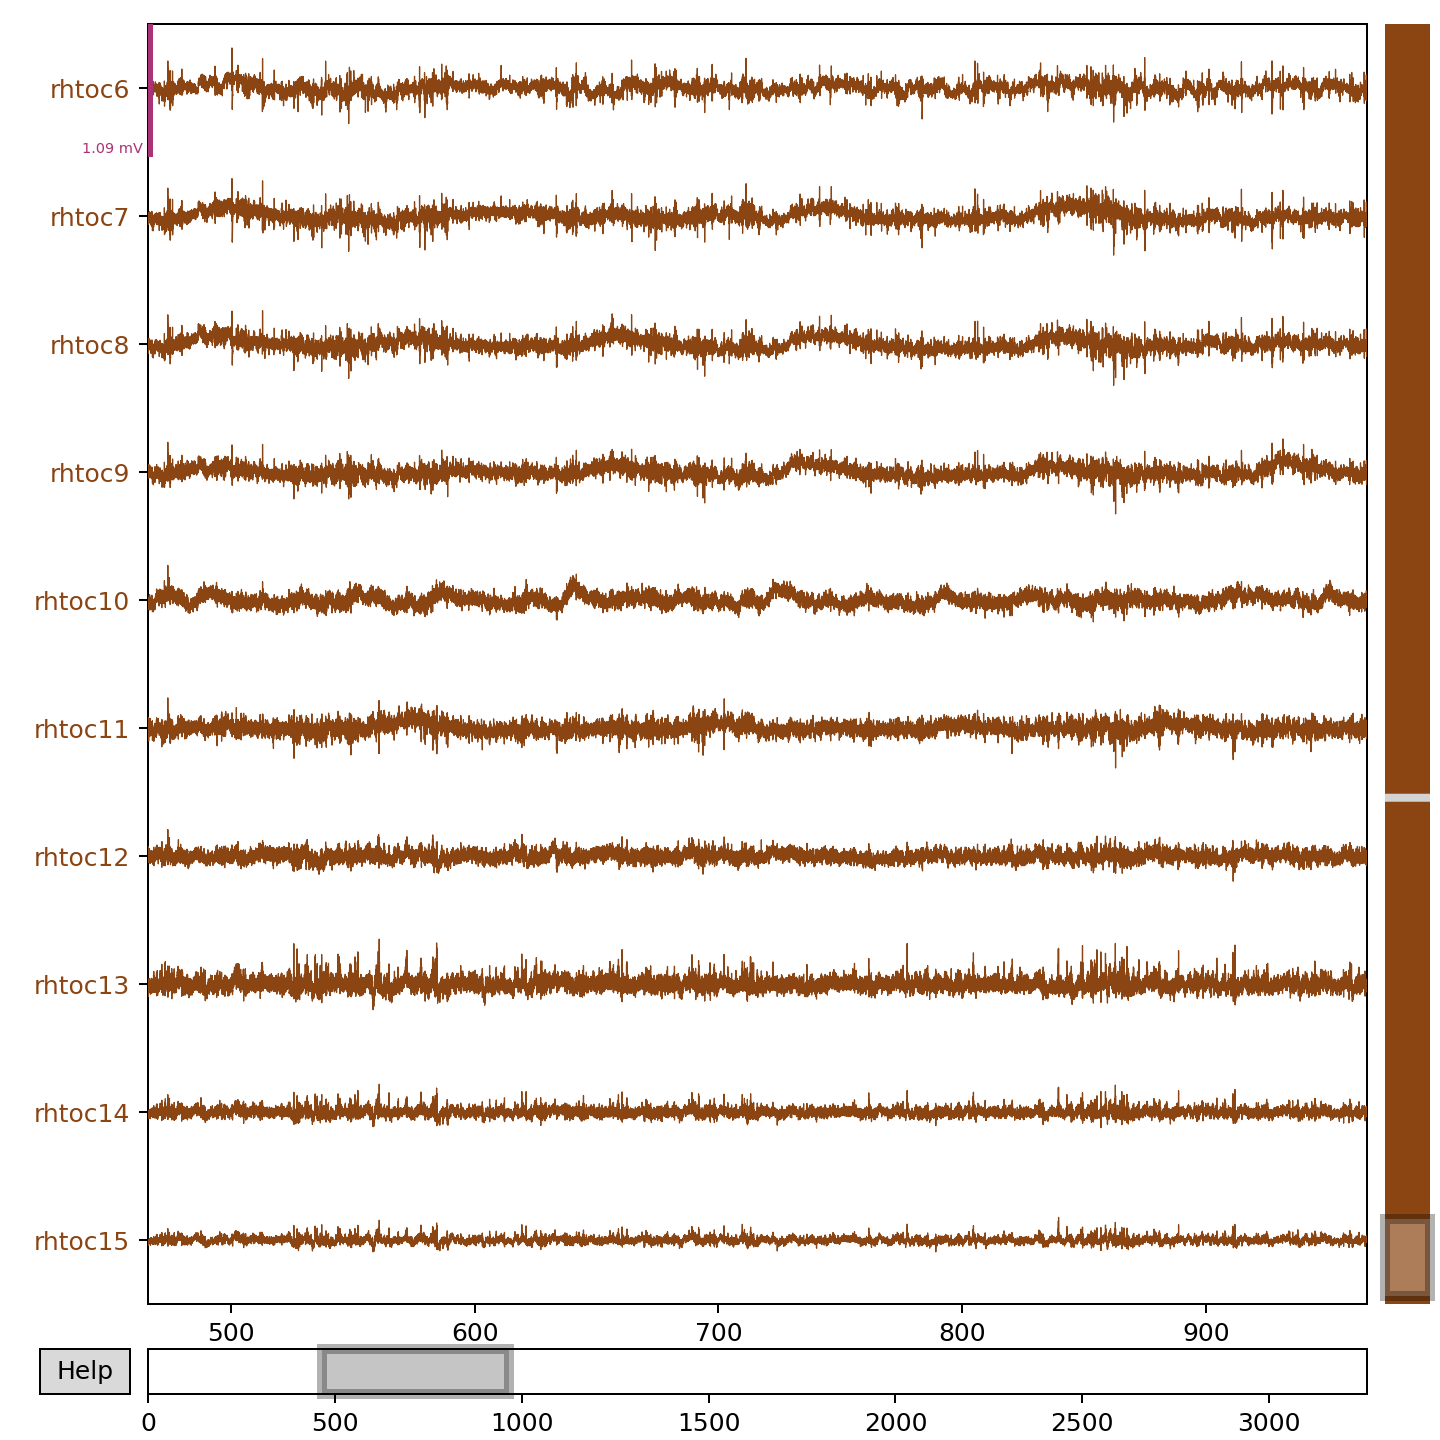

<IPython.core.display.Javascript object>


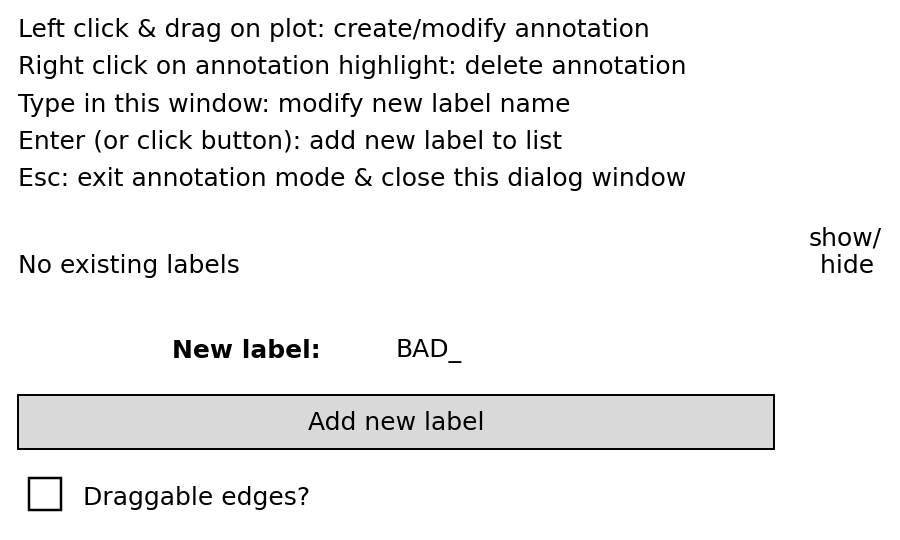

In [40]:
%matplotlib notebook 
fig = mne_data.plot(start=0, duration=500, n_channels=10, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [42]:
mne_data.info['bads']

['lhplt3', 'lmolf2', 'raglt2', 'rcmsp10', 'rhplt10', 'rmolf2']

<IPython.core.display.Javascript object>


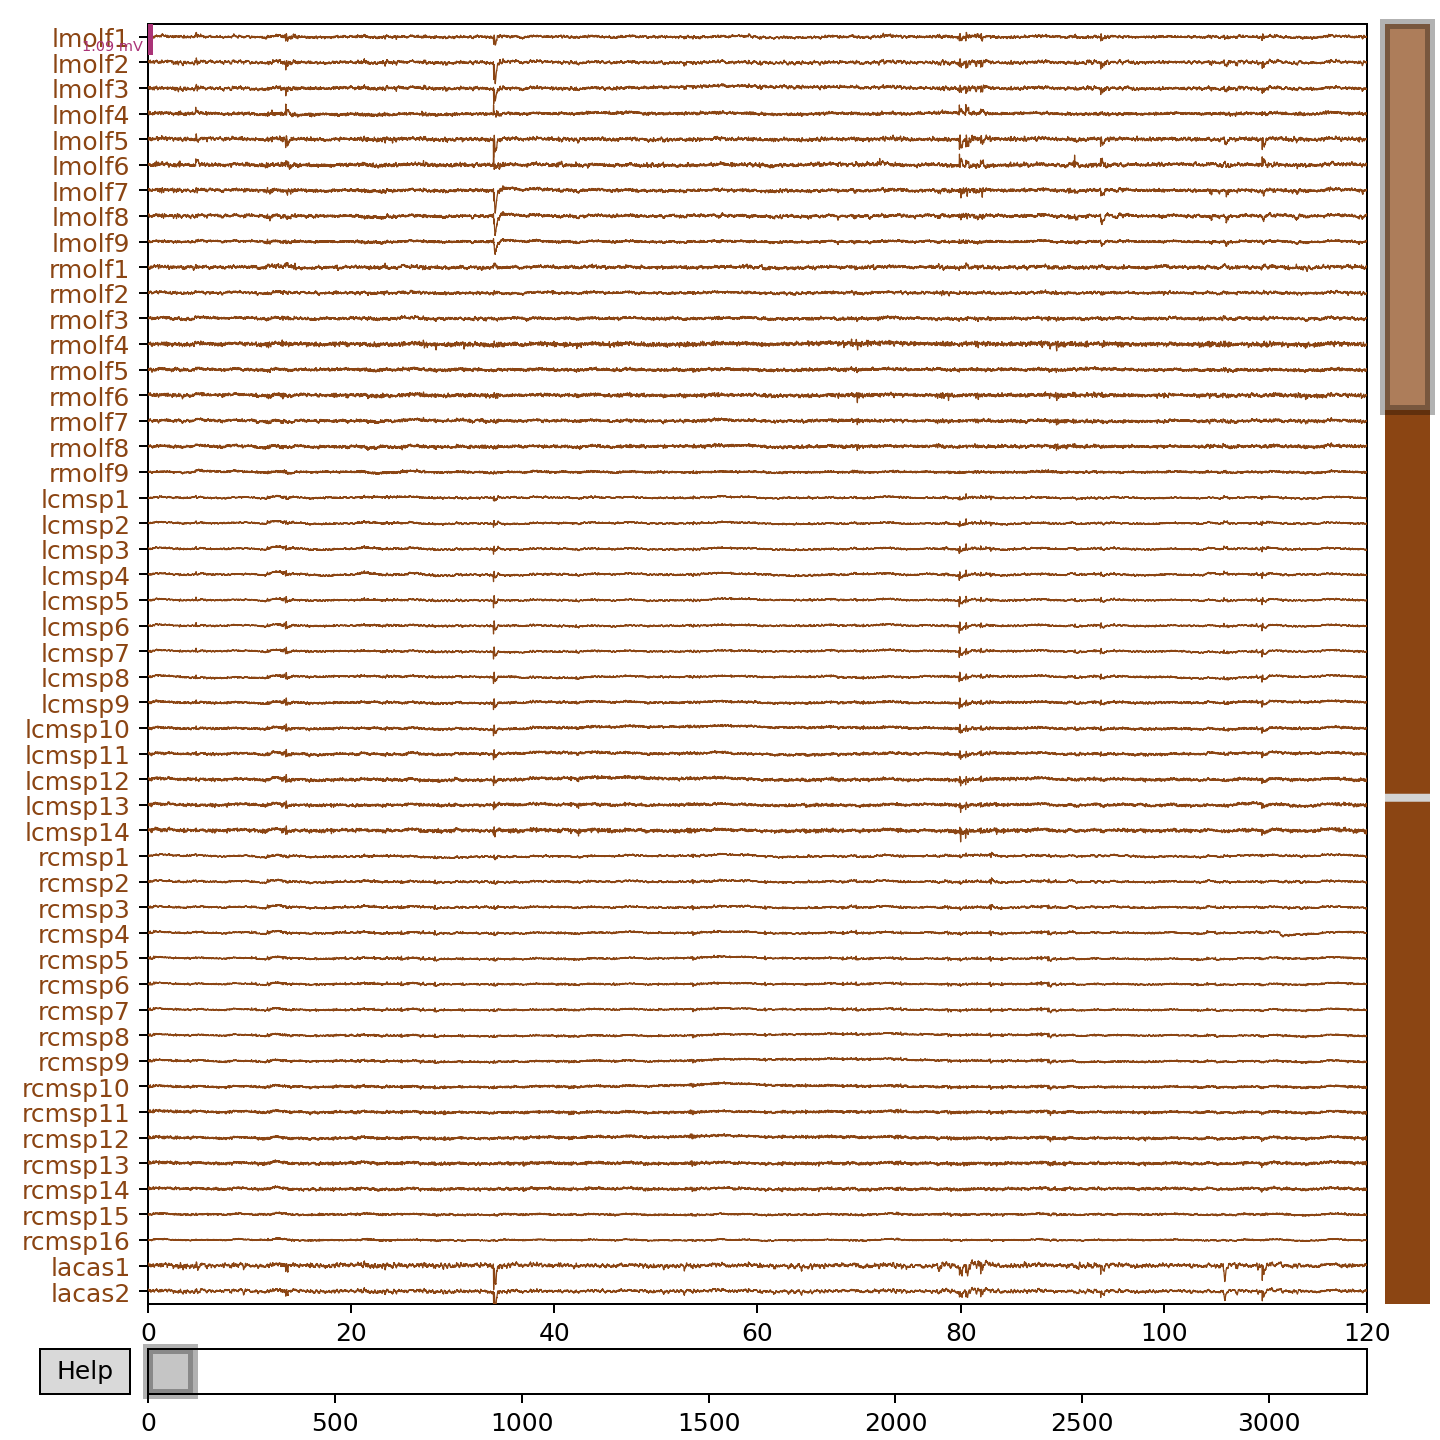

<IPython.core.display.Javascript object>


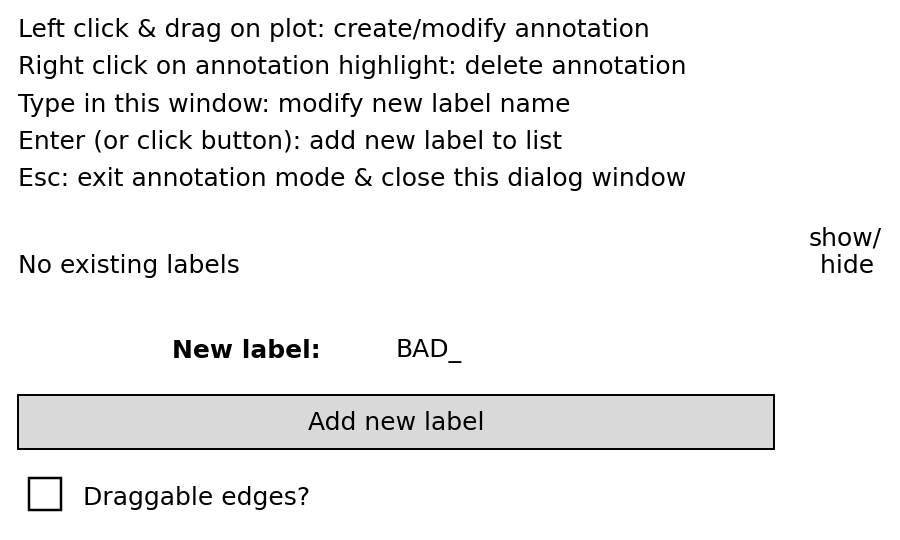

In [46]:
%matplotlib notebook
fig = mne_data.plot(start=0, duration=120, n_channels=50, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [47]:
mne_data.info['bads'] 

['laglt5']

In [48]:
#set bad channel info 
ms026_bad_ch = ['laglt5']



In [49]:
len(ms026_bad_ch)

1

In [50]:
#manually set bads because doing it in the plot is too buggy
mne_data.info['bads'] = ms026_bad_ch 

In [51]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 1 items (laglt5)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 166 sEEG
 custom_ref_applied: False
 dig: 164 items (164 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 256.0 Hz
 meas_date: 2001-01-01 11:15:14 UTC
 nchan: 166
 projs: []
 sfreq: 512.0 Hz
>

In [52]:
mne_data.info['bads'] #more sanity checking

['laglt5']

### Rereference data to wm electrodes

In [53]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(mne_data=mne_data, 
                                                                                elec_path=anat_file, 
                                                                                unmatched_seeg = unmatched_seeg,
                                                                                bad_channels=mne_data.info['bads'],
                                                                                      site = 'MSSM')

In [54]:
oob_channels

['lacas13',
 'lacas14',
 'lhplt10',
 'lhplt9',
 'lhtoc16',
 'lmcms10',
 'racas12',
 'racas13',
 'racas14',
 'rhtoc16',
 'rmcms10']

In [55]:
#need to distinguish between wm channels and oob channels 

#add oob channels to bad channels list
ms026_bad_ch = ms026_bad_ch + oob_channels
ms026_bad_ch = list(np.unique(ms026_bad_ch))
mne_data.info['bads'] = ms026_bad_ch

In [56]:
mne_data.info['bads'] #needed to rerun plotting function to find this again?

['lacas13',
 'lacas14',
 'laglt5',
 'lhplt10',
 'lhplt9',
 'lhtoc16',
 'lmcms10',
 'racas12',
 'racas13',
 'racas14',
 'rhtoc16',
 'rmcms10']

In [57]:
mne_data_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True)

In [59]:
mne_data_reref

<RawEDF | MS026_SWB.edf, 135 x 1670016 (3261.7 s), ~1.68 GB, data loaded>

### Save cleaned continuous data

In [60]:
mne_data.save(f'{neural_dir}/MS026/lfp_data.fif',overwrite=True)

In [61]:
mne_data_reref.save(f'{neural_dir}/MS026/wm_ref_ieeg.fif',overwrite=True)